# Neural Style Transfer
Gaty et. al, Image Style Transfer Using Convolutional Neural Networks, CVPR 2016

## Import Libraries
필요한 라이브러리들을 가져옵니다.

In [1]:
%pylab inline
import time
import os 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

from PIL import Image

from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!nvidia-smi

Wed Mar 24 11:26:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 45%   63C    P2    75W / 250W |   3043MiB / 12192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define Model
ImageNet 데이터를 이용해 이미 학습된 VGG 19 네트워크를 이용합니다.
VGG19 네트워크를 불러오기전에 먼저 네트워크를 정의합니다.

그리고 각 레이어들에 이름을 설정해둡니다.

In [4]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        #style_layers = ['r11','r21','r31','r41', 'r51'] 
        #content_layers = ['r42']
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

## Define loss and Gram matrix

아래 셀에서 Gram matrix와 loss를 구현해보세요.



In [5]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, x):
        ### Your code here ###

        
        #b,c,h,w = x.size()
        #F = x.view(c, h*w)
        #out = torch.mm(F, F.t())    
        
        _,c,_,_ = x.shape
        x_reshape = x.view(c, -1)
        out = x_reshape@x_reshape.t()
        
        
        
        ######################
        return out

class GramMSELoss(nn.Module):
    def forward(self, x, y):        
        ### Your code here ###
        
        out = nn.MSELoss()(GramMatrix()(x), y)
        
        
        ######################       
        return out

## Define parameters

여러분이 원하는 파라미터를 조절하여 보세요

1. `img_names`: style image로 사용할 이미지의 이름과 content image로 사용할 이미지의 이름을 정하는 변수
    * 코드를 완성하고 자유롭게 이미지를 올려서 실험해보세요.
 
    * ex) `['/path/to/style_image.jpg', '/path/to/content_image.jpg']`
    

2. `style_layers`: 어떤 layer의 feature와 style loss을 비교할지 정하는 변수
    * VGG의 forward 부분을 참고해서 자유롭게 정해보세요.
    
    
3. `content_layers`: 어떤 layer의 feature와 content loss를 비교할지 정하는 변수
    * VGG의 forward 부분을 참고해서 자유롭게 정해보세요.
    
    
4. `style_weights`: style_layers 변수에서 정한 layer에서의 weight
    * style_layers와 길이가 같아야 합니다.
    
    
5. `content_weights`: content_layers 변수에서 정한 layer에서의 weight
    * content_layers와 길이가 같아야 합니다.
    
    
6. `lr`: 나중에 optimizer의 초기 learning rate를 정해주는 변수
    * 값의 크기에 따라 수렴이 빠를수도 느릴수도 있습니다. 자유롭게 바꾸면서 가장 빨리 수렴하는 값을 찾아보세요.
    
    
7. `max_iter`: 최대 몇번까지 iteration 할지 정해주는 변수입니다.
    * 너무 값이 커도 너무 작아도 결과가 이상할 수 있습니다. 적당한 값을 찾아보세요.


8. `show_iter`: 변해가는 이미지를 확인하기 위해 얼마나 자주 결과를 출력할지 정해줍니다.

In [6]:
### Your parameters here ###
img_size = 512 

style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']

style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e-2]
content_weights = [1e0]

lr = 10

max_iter = 500
show_iter = 100
#############################

## Define dataloader

이미지를 불러오고 네트워크에 넣어주기 전 Tensor type으로 변환하고 RGB 값을 Normalize해 입력 형식을 맞춰줍니다.

최종 결과의 이미지를 확인하기 위해 denormalize하는 모듈을 선언하여 줍니다.

In [7]:
# pre and post processing for images

prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

## Load VGG

VGGNet을 정의하고 ImageNet 데이터셋으로 학습된 weight의 checkpoint를 다운받고 GPU로 로드합니다.

In [8]:
#get network
vgg = VGG()

while 1:
    try:
        vgg.load_state_dict(torch.load('vgg_conv.pth'))
        print("Model loaded!!")
        break
    except:
        print("Cannot load model, downloading new model!!")
        os.system('rm vgg_conv.pth')
        os.system('wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth')

for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

Model loaded!!


## Load image

Style image와 content image를 읽어오고 Tensor 타입으로 변경합니다.

만약 입력 이미지에 대한 경로가 정확하지 않을 경우 에러가 나면서 실행이 되지 않으니 입력 이미지의 이름을 확인해주세요.

In [9]:
#load images, ordered as [style_image, content_image]

style_image = './vangogh_starry_night.jpg'
if not os.path.isfile(style_image):
    os.system('wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/vangogh_starry_night.jpg')
    print(f'{style_image} download completed.')

content_image = './Tuebingen_Neckarfront.jpg'
if not os.path.isfile(content_image):
    os.system('wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/Tuebingen_Neckarfront.jpg')
    print(f'{content_image} download completed.')

"""
content_image = './42553_50200_2730.JPG'
if not os.path.isfile(content_image):
    os.system('wget http://www.digitaltoday.co.kr/news/photo/201401/42553_50200_2730.JPG')

content_image = './2071618_2066564_102.jpg'
if not os.path.isfile(content_image): 
    os.system('wget https://cdn.gukjenews.com/news/photo/202009/2071618_2066564_102.jpg')

content_image = 'pa89n23zvzl5y36t3j27.jpg'
if not os.path.isfile(content_image):
    os.system('wget https://img.insight.co.kr/static/2017/08/08/700/pa89n23zvzl5y36t3j27.jpg')
    
content_image = 'cfile26.uf.223952375358B8E10A9FCE.jpg'
if not os.path.isfile(content_image):
    os.system('wget https://insight-prd-data.s3.ap-northeast-2.amazonaws.com/wp-content/uploads/2/cfile26.uf.223952375358B8E10A9FCE.jpg')
"""
    
img_names = [style_image, content_image]

imgs = [Image.open(name) for i,name in enumerate(img_names)]
print('Image loaded!!')

Image loaded!!


In [10]:
!ls

1.Before_style_transfer.ipynb	       histogram.ipynb
2071618_2066564_102.jpg		       pa89n23zvzl5y36t3j27.jpg
2.style_transfer-answers.ipynb	       result.png
2.style_transfer.ipynb		       Tuebingen_Neckarfront.jpg
42553_50200_2730.JPG		       vangogh_starry_night.jpg
cfile26.uf.223952375358B8E10A9FCE.jpg  vgg_conv.pth


## preprocessing

In [11]:
imgs_torch = [prep(img) for img in imgs]
imgs_torch = [img.unsqueeze(0).to(device) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = torch.randn(content_image.size()).type_as(content_image.data) #random init
opt_img = content_image.data.clone() # Init as content image

In [12]:
opt_img.requires_grad = True

## Show input images

입력으로 사용된 Style image와 Content image를 보여줍니다.

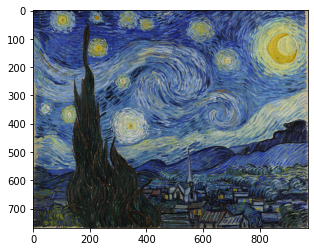

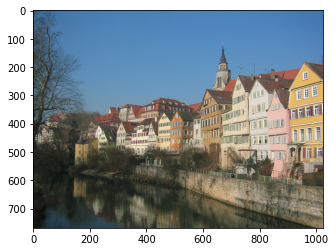

In [13]:
#display images
for img in imgs:
    imshow(img);show()

## Define loss
비교 기준이 되는 style feature와 content feature의 값을 구하고 loss를 구현합니다.

In [14]:
#define layers, loss functions, weights and compute optimization targets

loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]
    
#weights setting:
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

## Training
직접적으로 학습이 수행됩니다.

Unlike training a network, we want to train the input image in order to minimise the content/style losses

여러가지 optimizer들을 사용하고 parameter를 바꿔보면서 가장 좋은 결과를 만들어보세요.

Iteration: 001, loss: 6.975186661487411e+16


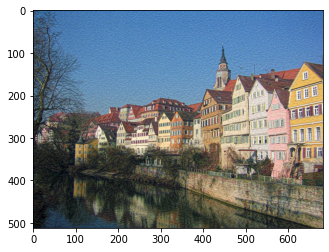

Iteration: 101, loss: 32668769058816.0


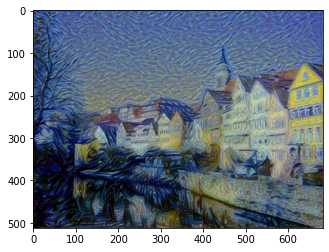

Iteration: 201, loss: 11395214082048.0


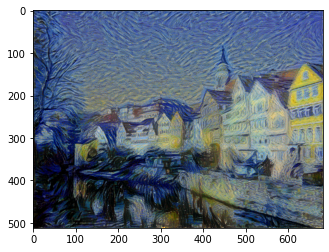

Iteration: 301, loss: 6678931046400.0


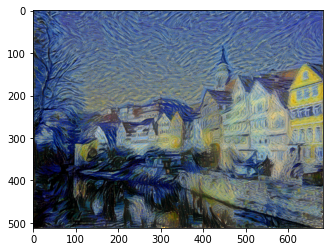

Iteration: 401, loss: 4850835259392.0


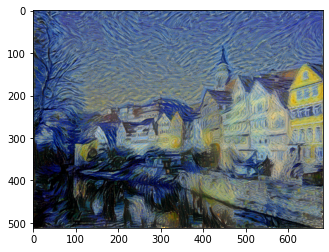

In [15]:
# Define optimizer
optimizer = optim.Adam([opt_img], lr)

#run style transfer
for n_iter in range(max_iter):
    optimizer.zero_grad()
    out = vgg(opt_img, loss_layers)
    layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
    loss = sum(layer_losses)
    loss.backward()

    optimizer.step()
    
    # Print loss and Show output image
    if n_iter % show_iter == 0:
        print('Iteration: {:03d}, loss: {}'.format(n_iter+1, loss.item()))
        #display result
        out_img = postp(opt_img.data[0].cpu().squeeze())
        imshow(out_img)
        show()
        #gcf().set_size_inches(10,10)



## Show final result

Style transfer의 최종 결과를 큰 사이즈로 출력합니다.

Final Result!!


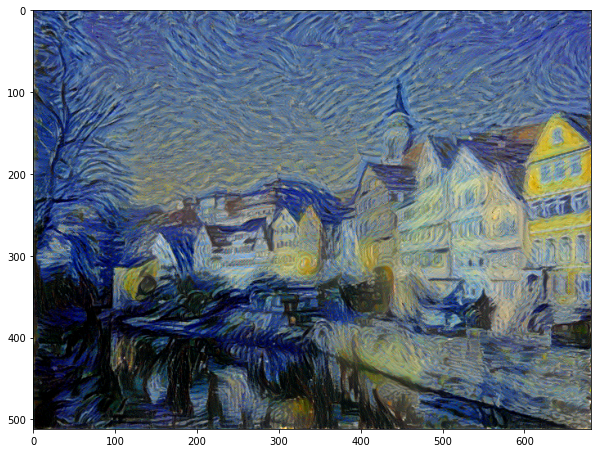

In [16]:
#display result
print("Final Result!!")
out_img = postp(opt_img.data[0].cpu().squeeze())
gcf().set_size_inches(10,10)
imshow(out_img)
show()

# save the result image
out_img.save('./result.png')

In [17]:
!ls

1.Before_style_transfer.ipynb	       histogram.ipynb
2071618_2066564_102.jpg		       pa89n23zvzl5y36t3j27.jpg
2.style_transfer-answers.ipynb	       result.png
2.style_transfer.ipynb		       Tuebingen_Neckarfront.jpg
42553_50200_2730.JPG		       vangogh_starry_night.jpg
cfile26.uf.223952375358B8E10A9FCE.jpg  vgg_conv.pth
